In [1]:
import os
import requests
import cv2
import argparse
import warnings
import numpy as np
import random
import math
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
from itertools import cycle
from multiprocessing import Pool
from pdf2image import convert_from_path
from pdf2image.exceptions import PDFInfoNotInstalledError
from typing import List, Tuple
from PIL import Image
from decimer_segmentation.complete_structure import complete_structure_mask
from decimer_segmentation.mrcnn.config import Config
from decimer_segmentation.mrcnn import model as modellib
from decimer_segmentation.mrcnn import visualize
from decimer_segmentation.mrcnn import moldetect
from decimer_segmentation.mrcnn import utils

2023-12-14 17:04:45.836329: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 17:04:45.881671: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 17:04:45.881699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 17:04:45.882817: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 17:04:45.890170: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 17:04:45.891036: I tensorflow/core/platform/cpu_feature_guard.cc:1

Instructions for updating:
Use fn_output_signature instead


In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
class InferenceConfig(moldetect.MolDetectConfig):
    """
    Inference configuration class for MRCNN
    """

    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

In [3]:
# Define directory with trained model weights
model_path = 'decimer_segmentation/mask_rcnn_molecule.h5'

In [ ]:

# Download trained weights if needed
if not os.path.exists(model_path):
    print("Downloading model weights...")
    url = "https://zenodo.org/records/10142866/files/mask_rcnn_molecule.h5?download=1"
    req = requests.get(url, allow_redirects=True)
    with open(model_path, "wb") as model_file:
        model_file.write(req.content)
    print("Successfully downloaded the segmentation model weights!")
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=".", config=config)

# Load weights
model.load_weights(model_path, by_name=True)

# Process to Train

In [4]:
class TrainConfig(moldetect.MolDetectConfig):
    """
    Traning configuration class for MRCNN
    """

    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [5]:
# Create model in training mode
model_train = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=".")

In [7]:
# Load weights
model_train.load_weights(model_path, by_name=True)

In [8]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Dataset Toy Test
Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, load_shapes(), and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [13]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        np.bool = np.bool_
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [14]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(3, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(1, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

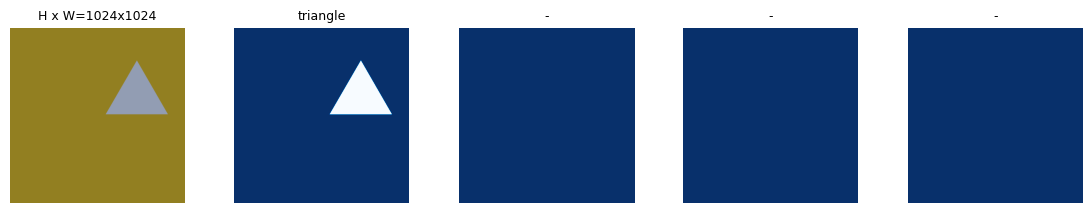

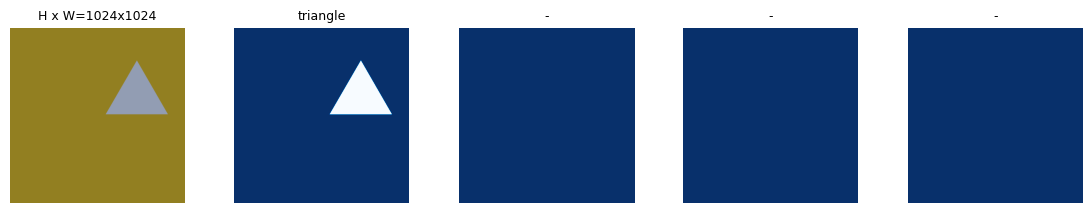

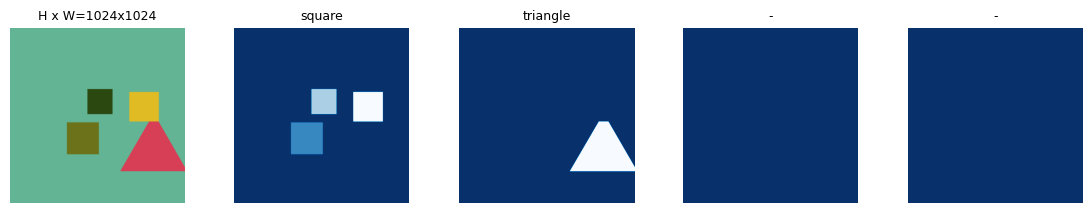

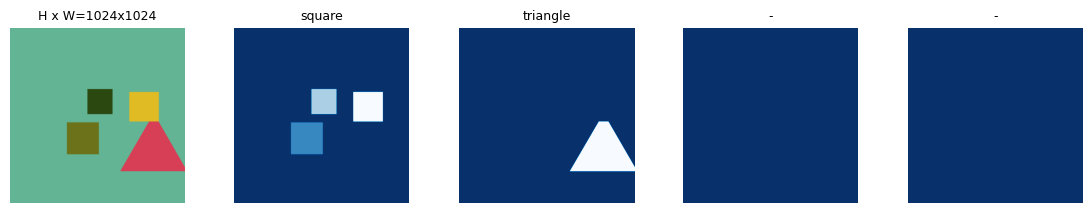

In [15]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


In [16]:
from tensorflow.keras.callbacks import ProgbarLogger
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

model_train.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads',
            custom_callbacks=[ProgbarLogger()])

2023-12-14 17:28:23.341711: W tensorflow/c/c_api.cc:305] Operation '{name:'bn4w_branch2c/moving_variance/Assign' id:4891 op device:{requested: '', assigned: ''} def:{{{node bn4w_branch2c/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bn4w_branch2c/moving_variance, bn4w_branch2c/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-14 17:28:25.738571: W tensorflow/c/c_api.cc:305] Operation '{name:'range' id:11856 op device:{requested: '', assigned: ''} def:{{{node range}} = Range[Tidx=DT_INT32, _has_manual_control_dependencies=true](range/start, Rank, range/delta)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't

KeyboardInterrupt: 

In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [ ]:
dir = "./dataset/train/instances_default.json"

In [ ]:
coco=COCO(dir)

In [ ]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

In [ ]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['bar', 'diagram', 'flow', 'graph', 'growth', 'pie'])
catIds
# imgIds = coco.getImgIds(catIds=catIds );
# imgIds = coco.getImgIds(imgIds = [324158])
# img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [ ]:
imgIds = coco.getImgIds(catIds=catIds )
imgIds

In [ ]:
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [1])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [ ]:
img

In [ ]:
img['file_name']

In [ ]:
I = io.imread("dataset/train/"+img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [ ]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
anns

In [ ]:
#load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns,draw_bbox=True)